In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import Generator
import config
from Dataset import RealGlasses
from utils import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image

In [2]:
# plt.figure(figsize=(24, 24))
# plt.imshow(Image.open("know_your_translation.PNG"))
# plt.show()
#

Showcase of trained model prediction on random loaded image

In [3]:
# plt.figure(figsize=(24, 24))
# plt.imshow(Image.open("alpha_scaling.PNG"))
# plt.show()
#

In [4]:
# plt.figure(figsize=(24, 24))
# plt.imshow(Image.open("sys_overview.PNG"))
# plt.show()
#

In [5]:
# plt.figure(figsize=(24, 24))
# plt.imshow(Image.open("Generator.PNG"))
# plt.show()
#

In [6]:
# plt.figure(figsize=(24, 24))
# plt.imshow(Image.open("discriminator.PNG"))
# plt.show()

In [7]:
gen = Generator(img_size=config.IMAGE_SIZE)
optim_placeholder = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE)
# load_checkpoint("log/6epoch/g_checkpoint.pth.tar", gen, optim_placeholder, config.LEARNING_RATE)
# load_checkpoint("g_checkpoint.pth.tar", gen, optim_placeholder, config.LEARNING_RATE)
load_checkpoint("log/g_8poch.pth.tar", gen, optim_placeholder, config.LEARNING_RATE)
gen.to("cpu")
gen.eval()
warp = dense_warp_field(device="cpu")


=> Loading checkpoint


In [8]:
dataset = RealGlasses(config.ACTUAL_GLASSES_ROOT, transform=transform_eval)
loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=0)

for i, cls in loader:
    output = i#.to(config.DEVICE)
    target_cls = cls#.to(config.DEVICE)
    print(torch.max(output), torch.min(output))
    break
#
#

tensor(1.) tensor(-1.)


D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,


xtensor([[0.4424, 0.3692],
        [0.3888, 0.4024],
        [0.3889, 0.3766]])
ytensor([[0.4424, 0.3692],
        [0.4736, 0.3879],
        [0.5018, 0.3757]])
xtensor([[0.4424, 0.3692],
        [0.3888, 0.4024],
        [0.3889, 0.3766]])
ytensor([[0.4424, 0.3692],
        [0.4736, 0.3879],
        [0.5018, 0.3757]])
Warp field size:torch.Size([16, 128, 128, 2])
warped image size:torch.Size([16, 3, 128, 128])


D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


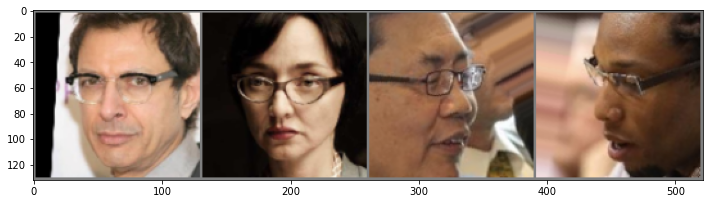

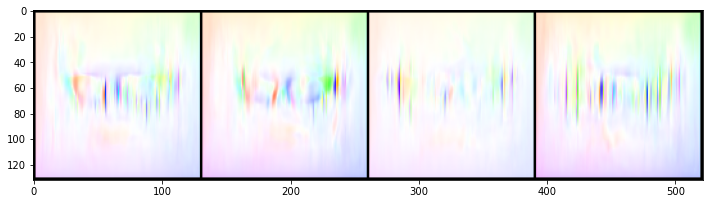

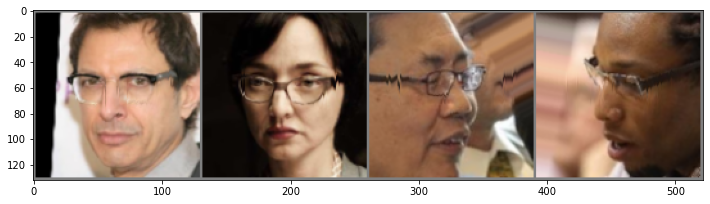

In [9]:
alpha = 1
y_shift = 1
x_shift = 1

with torch.no_grad():
    warp_field = gen(output, target_cls).cpu()
    
    print(f"x{warp_field[0,0,0:3,:]}")
    
    print(f"y{warp_field[0,0:3,0,:]}")
    warp_field[...,0] = warp_field[...,0] * x_shift
    warp_field[...,1] = warp_field[...,1] * y_shift
    
    print(f"x{warp_field[0,0,0:3,:]}")
    
    print(f"y{warp_field[0,0:3,0,:]}")
    
    print(f"Warp field size:{warp_field.shape}")
    warped_image = warp(output.cpu(), warp_field * alpha)
    print(f"warped image size:{warped_image.shape}")
    plt.figure(figsize=(12, 12))
    plt.imshow((make_grid(output[:4]).permute(1,2,0)*0.5 + 0.5).cpu())
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.imshow((make_grid(torch.Tensor(flows_to_image(warp_field[:4].detach().cpu())).permute(0,3,1,2)).permute(1,2,0)).cpu())
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.imshow((make_grid(warped_image[:4]).permute(1,2,0)*0.5 + 0.5).cpu())
    plt.show()

torch.Size([4, 1024, 1024, 2])
torch.Size([3, 1028, 4106]) torch.Size([3, 1028, 4106]) torch.Size([3, 1028, 4106])


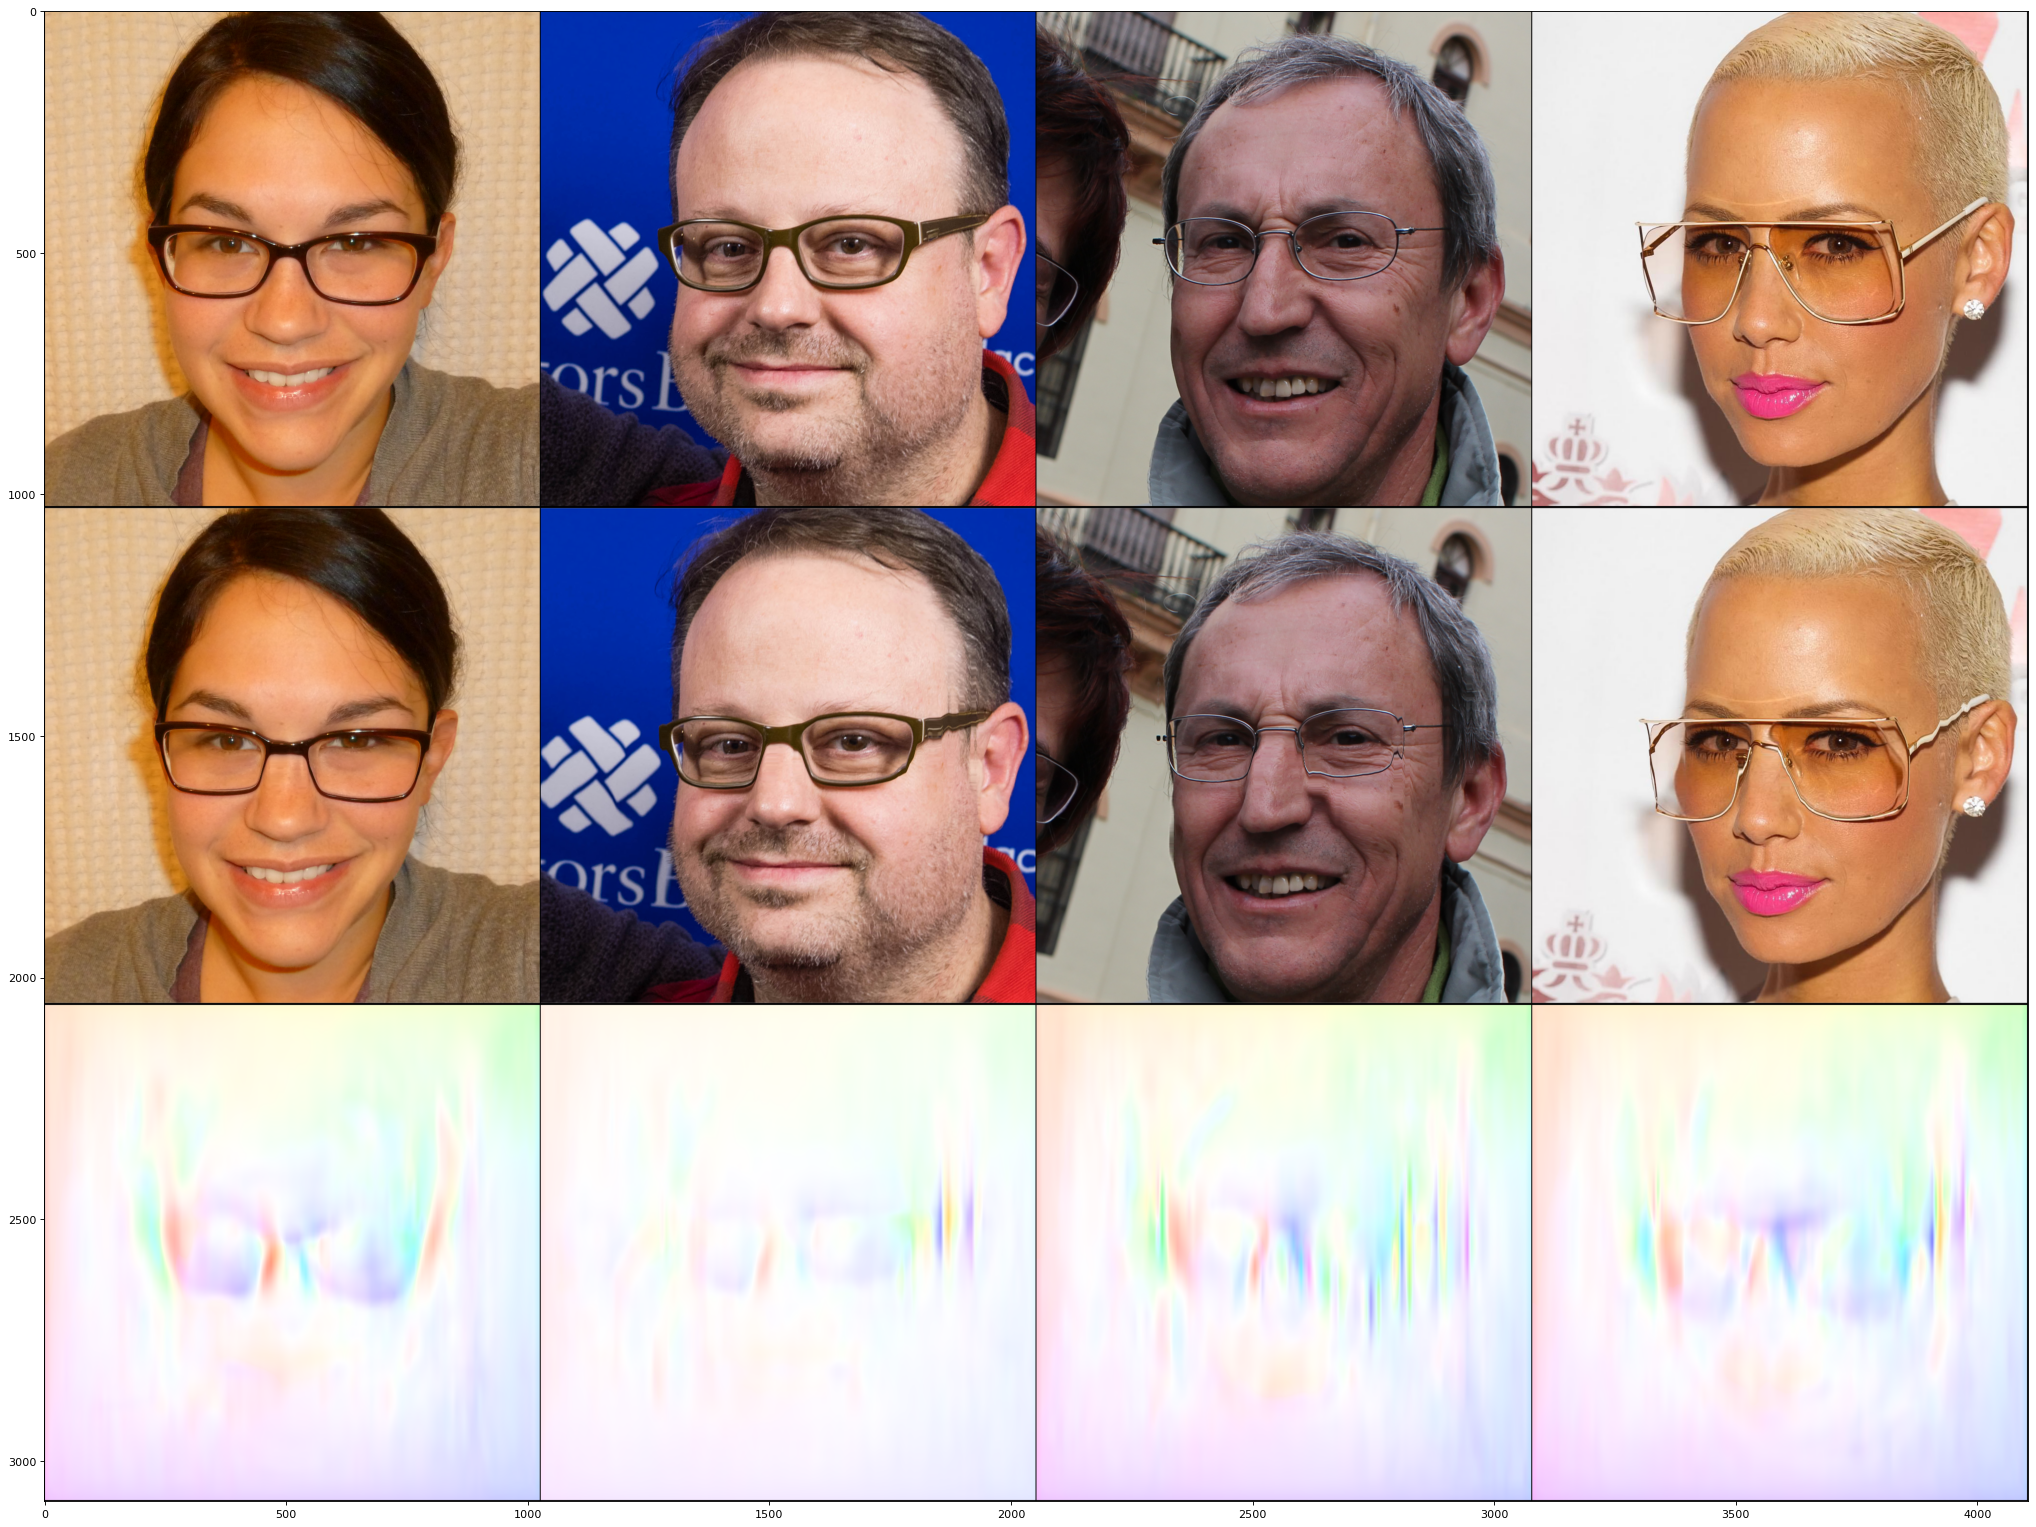

In [10]:

y_shift = 0
x_shift = 2.5 #2.5


with torch.no_grad():
    path = "example3"
    eval_imgs_list = os.listdir(path)
    eval_imgs = []
    eval_imgs_tranform = []
    for img in eval_imgs_list:
        img = Image.open(os.path.join(path, img))
        album = transform_eval(image=np.array(img))
        eval_imgs_tranform.append(album["image"].unsqueeze(0))
        album = transform_original(image=np.array(img))
        eval_imgs.append(album["image"].unsqueeze(0))
    eval_imgs = torch.cat(eval_imgs, dim=0)
    eval_imgs_tranform = torch.cat(eval_imgs_tranform, dim=0)

    upsample = nn.Upsample(scale_factor=8, mode="bilinear")
    upsampled_warp = dense_warp_field(shape=[1024, 1024], batch=eval_imgs.shape[0], device="cpu")

    #Predict and up sample
    cls = torch.Tensor([0, 1]).repeat(eval_imgs_tranform.shape[0], 1)
    eval_warp = upsample(gen(eval_imgs_tranform, cls).permute(0, 3, 1, 2))
    eval_warp_visualize = torch.Tensor(flows_to_image(eval_warp.detach().cpu()))

    #Apply alpha and two direction shifting

    eval_warp = eval_warp.permute(0, 2, 3, 1) / config.IMAGE_SIZE * 1024 
    eval_warp[...,0] = eval_warp[...,0] * x_shift
    eval_warp[...,1] = eval_warp[...,1] * y_shift

    print(eval_warp.shape)


    eval_fake_imgs = upsampled_warp(eval_imgs, eval_warp)

    print(make_grid(eval_imgs * 0.5 + 0.5).shape,
          make_grid(eval_fake_imgs * 0.5 + 0.5).shape,
          make_grid(eval_warp_visualize.permute(0, 3, 1, 2) * 0.5 + 0.5).shape)
    eval_result = torch.cat([make_grid(eval_imgs * 0.5 + 0.5), make_grid(eval_fake_imgs * 0.5 + 0.5), make_grid(eval_warp_visualize.permute(0, 3, 1, 2) * 0.5 + 0.5)], dim = 1)
    figure(figsize=(32, 32), dpi=80)
    plt.imshow(eval_result.permute(1,2,0))
    plt.show()